In [ ]:
import tensorflow as tf

# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-6mxft3w3
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-6mxft3w3
  Resolved https://github.com/tensorflow/docs to commit 2bcfa24e59cb9293fbb57d0c1e2f8b16ecf83e65
  Preparing metadata (setup.py) ... done


In [ ]:
tf.__version__

'2.13.0'

In [ ]:



tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
import keras.backend as K

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]


BUFFER_SIZE = 60000
BATCH_SIZE = 256
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
print(train_images.shape)

(60000, 28, 28, 1)


In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [ ]:
def make_critic_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

tf.Tensor([[-0.0025544]], shape=(1, 1), dtype=float32)


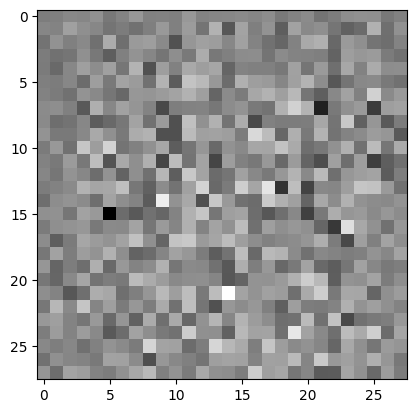

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

critic = make_critic_model()
decision = critic(generated_image)
print (decision)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def wasserstein(y_true, y_pred):
    return -K.mean(y_true * y_pred)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
critic_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005)

critic.compile(
optimizer= critic_optimizer
, loss = wasserstein
)

generator.compile(
optimizer= generator_optimizer
, loss = wasserstein
)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 critic_optimizer=critic_optimizer,
                                 generator=generator,
                                 critic=critic)

In [ ]:
EPOCHS = 15
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:

def train_critic(x_train, batch_size, clip_threshold):
    valid = np.ones((batch_size,1))
    fake = -np.ones((batch_size,1))
    # TRAIN ON REAL IMAGES
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    true_imgs = train_images[idx]
    critic.train_on_batch(true_imgs, valid)
    # TRAIN ON GENERATED IMAGES
    noise = np.random.normal(0, 1, (batch_size, noise_dim))
    gen_imgs = generator.predict(noise)
    critic.train_on_batch(gen_imgs, fake)
    for l in critic.layers:
        weights = l.get_weights()
        weights = [np.clip(w, -clip_threshold, clip_threshold) for w in weights]
        l.set_weights(weights)

In [ ]:

def train_generator(batch_size):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    true_output = np.ones((batch_size,1))
    with tf.GradientTape() as gen_tape:
      generated_images = generator(noise, training=True)
      fake_output = critic(generated_images, training=True)
      gen_loss = wasserstein(true_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))


In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:

def train(dataset, epochs):
  for epoch in range(16, epochs+16):
    #print("epoch is {} ".format(epoch))
    start = time.time()

    for image_batch in dataset:
      for _ in range(5):
        #print("critic traning:{}".format(_))
        train_critic(x_train=train_images, batch_size = BATCH_SIZE, clip_threshold = 0.01)
      train_generator(BATCH_SIZE)
      #print("generator trained")




    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

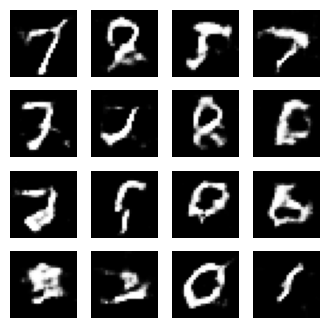

Time for epoch 28 is 177.3414855003357 sec
8/8 [==============================] - 29s 2s/step


In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
anim_file = 'wgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-3-539c20e330ff>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-3-539c20e330ff>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



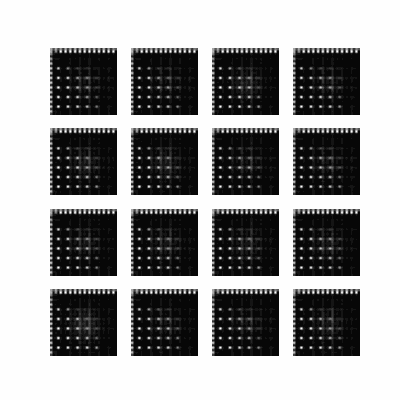

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)